In [1]:
import numpy as np
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from nltk import ngrams
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Eric\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Using TensorFlow backend.


In [7]:
def tokenizeFile(fileName: str) -> list:
    '''Will take in the name of a txt file located in the base directory 
    of the drive and return a list of tokens. Tokens are defined to be
    any nonzero sequence of characters.'''
    tokens = []
    with open(fileName, 'r', encoding="ISO-8859-1") as file:
        s = file.read()
        s = s.replace('\n', ' NEWLINETOKEN ') # Use a character you would never find in code
        s = s.replace('\t', ' TABTOKEN ')
        tokens = word_tokenize(s)
        tokens = ['\n' if t == 'NEWLINETOKEN' else t for t in tokens ]
        tokens = ['\t' if t == 'TABTOKEN' else t for t in tokens ]
    return list(tokens)

In [8]:
# Import the dataset
# tokens_all = tokenizeFile("TheLordOfTheRings_Book1.txt")
tokens_all = tokenizeFile("linux_kernel_concat.c")

In [10]:
# Cut number of words so we can fit everything in memory
tokens = tokens_all[:len(tokens_all)//10]
# tokens = tokens_all[:len(tokens_all)]
print('Total Tokens: %d' % len(tokens))
print('Unique Tokens: %d' % len(set(tokens)))

# Change this parameter to decrease or increase the size of the training samples
N = 20
ngrams_tokens = list(ngrams(tokens, N))
np.random.shuffle(ngrams_tokens)
print('Total ngrams: %d' % len(ngrams_tokens))

# Combine tokens into training sample phrases
ngrams_samples = [" ".join(x) for x in ngrams_tokens]
print("Total Samples: %d" % len(ngrams_samples))

Total Tokens: 37589
Unique Tokens: 3059
Total ngrams: 37570
Total Samples: 37570


Assign a unique ID to each token and make an inverted index so we can look up terms easily later.

Determine the vocabulary size for the Embedding layer.

In [12]:
tokenizer = Tokenizer(filters='')
# tokenizer = Tokenizer(filters='\t\n')
tokenizer.fit_on_texts(ngrams_samples)
sequencies = np.array(tokenizer.texts_to_sequences(ngrams_samples))
# sequencies = tokenizer.texts_to_sequences(ngrams_samples)
vocab_size = len(tokenizer.word_index) + 1
print("Sequences Shape: " + str(sequencies.shape))
print("Vocabulary size: %d" % vocab_size)

Sequences Shape: (37570, 20)
Vocabulary size: 2928


Split into training, validation, and testing

Split into input and expected output where the input is all but the last token and the output is the last token

In [13]:
from numpy import array as ar

tr = int(len(sequencies) * 0.9) # Training samples is 90% of data
va = int(len(sequencies) * 0.95) # Validation samples is 5% of data 
te = len(sequencies) # Testing samples is last 5% of data
training, validation, testing = sequencies[:tr], sequencies[tr:va], sequencies[va:te]

tr_input, tr_output = ar([x[:-1] for x in training]), [x[-1] for x in training]
tr_output = to_categorical(tr_output, num_classes=vocab_size)

va_input, va_output = ar([x[:-1] for x in validation]), [x[-1] for x in validation]
va_output = to_categorical(va_output, num_classes=vocab_size)

te_input, te_output = ar([x[:-1] for x in testing]), [x[-1] for x in testing]
te_output = to_categorical(te_output, num_classes=vocab_size)

In [14]:
seq_length = tr_input.shape[1]
print(seq_length)

19


In [15]:
model = Sequential()
model.add(Embedding(vocab_size, 300, input_length=seq_length))
model.add(LSTM(300, return_sequences=True))
model.add(LSTM(300))
model.add(Dense(300, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 19, 300)           878400    
_________________________________________________________________
lstm_1 (LSTM)                (None, 19, 300)           721200    
_________________________________________________________________
lstm_2 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 2928)              881328    
Total params: 3,292,428
Trainable params: 3,292,428
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(tr_input, tr_output, batch_size=32, epochs=50, validation_data=(va_input, va_output))

Train on 33813 samples, validate on 1878 samples
Epoch 1/50
33813/33813 [==============================] - 65s 2ms/step - loss: 4.3342 - acc: 0.2652 - val_loss: 3.7388 - val_acc: 0.3557
Epoch 2/50
33813/33813 [==============================] - 61s 2ms/step - loss: 3.4377 - acc: 0.3862 - val_loss: 3.4519 - val_acc: 0.4137
Epoch 3/50
33813/33813 [==============================] - 61s 2ms/step - loss: 3.0188 - acc: 0.4445 - val_loss: 3.2233 - val_acc: 0.4542
Epoch 4/50
33813/33813 [==============================] - 61s 2ms/step - loss: 2.7242 - acc: 0.4818 - val_loss: 3.1608 - val_acc: 0.4760
Epoch 5/50
33813/33813 [==============================] - 61s 2ms/step - loss: 2.4925 - acc: 0.5055 - val_loss: 3.1228 - val_acc: 0.4968
Epoch 6/50
33813/33813 [==============================] - 61s 2ms/step - loss: 2.3040 - acc: 0.5247 - val_loss: 3.0954 - val_acc: 0.5059
Epoch 7/50
33813/33813 [==============================] - 61s 2ms/step - loss: 2.1309 - acc: 0.5415 - val_loss: 3.1222 - val_acc:

In [17]:
from matplotlib import pyplot as plt

def plot_accuracy(history):
    plt.plot(history.history['acc'],label='train')
    if 'val_acc' in history.history:
        plt.plot(history.history['val_acc'],label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy during Training')
    plt.show()
    
def plot_loss(history):
    plt.plot(history.history['loss'],label='train')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'],label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss during Training')
    plt.show()

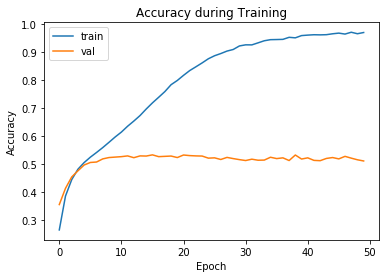

In [18]:
plot_accuracy(history)

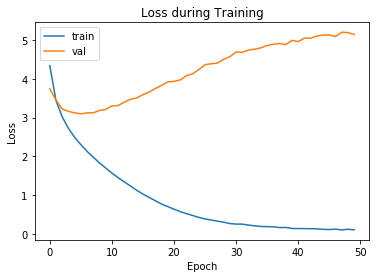

In [19]:
plot_loss(history)

In [20]:
from random import randint
seed_text = ngrams_samples[randint(0, len(ngrams_samples))]
print(seed_text)

	 uint32_t *genpoly ; 
 	 struct bch_control *bch = NULL ; 
 
 	 const int min_m = 5


In [26]:
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
    result = list()
    in_text = seed_text
    # generate a fixed number of words
    for _ in range(n_words):
        # encode the text as integer
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        # truncate sequences to a fixed length
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        # predict probabilities for each word
        yhat = model.predict_classes(encoded, verbose=0)
        # map predicted word index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        # append to input
        in_text += ' ' + out_word
        result.append(out_word)
    return ' '.join(result)

# generate new text
generated = generate_seq(model, tokenizer, seq_length, seed_text, 500)
print(generated)

; 
 	 const int ecclen = bch_ecc_words ( bch ) -1 ; 
 
 	 while ( len ) { 
 	 	 q- > deg = 0 ; 
 	 	 q- > c [ 0 ] = c ; 
 	 } 
 	 return v ; 
 } 
 export_symbol ( _bin2bcd ) ; 
 
 /** 
 * same as encode_bch - calculate positive parity of pages 
 * 	 from aio_get_req ( ) encounters return and move it after be supported 
 * 
 * the exact electronics specified is distributed in the given by 
 * them . 
 */ 
 static int br_device_event ( struct notifier_block *unused , unsigned long bugaddr , 
 	 	 	 	 struct page *pages , phys_addr_t unused , const uint8_t iocb- > 
 	 	 	 	 struct cma __user * + prot_write , bool compat ) 
 { 
 	 	 mutex_unlock ( & cma- > lock ) ; 
 	 } 
 } 
 
 static int __init br_init ( void ) 
 { 
 	 int i ; 
 
 	 build_bug_on ( sizeof ( *table ) ; 
 
 err : 
 	 local_irq_restore ( page ) ; 
 
 	 if ( ! device ) 
 	 	 return -einval ; 
 
 	 mask = cma_bitmap_aligned_mask ( cma , align ) ; 
 	 offset = cma_bitmap_aligned_offset ( cma , align ) ; 
 	 bitmap_maxno = ( voi

In [ ]:
# Grab some fun examples